In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.stats as ss
from sklearn.linear_model import LinearRegression
import csv
from keras.models import load_model
from pkg_resources import resource_filename
from spliceai.utils import one_hot_encode
from maxentpy import maxent
from collections import Counter
import itertools
import matplotlib

Using TensorFlow backend.


In [2]:
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
import os.path as op

In [4]:
import seaborn as sns

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp
import splanl.custom_splai_scores as css
import splanl.create_vcf as vcf

In [7]:
matplotlib.rc_file_defaults()
plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.rcParams[ 'font.sans-serif' ] = "Arial"
plt.rcParams[ 'font.family' ] = "sans-serif"

In [8]:
chr11 = '/nfs/kitzman2/lab_common2/refs/human/ucsc_hg19/bychrom/chr11.fa'
chr11_seq = pp.get_refseq( chr11 )[ 'chr11' ]

In [9]:
fa_file = '/nfs/kitzman2/jacob/proj/jensplice/20220415_wt1_mpsa_trial3/jkp1053_1054_1055.fa'
refseq = pp.get_refseq( fa_file )[ 'jkp1053_1054_1055' ]

In [10]:
github_colors = '3182bd6baed69ecae1c6dbefe6550dfd8d3cfdae6bfdd0a231a35474c476a1d99bc7e9c0756bb19e9ac8bcbddcdadaeb636363969696bdbdbdd9d9d9'

In [11]:
light_colors = [ '#' + github_colors[i:i+6] for i in range( 0, len( github_colors ), 6 ) ]

In [12]:
tab20 = cm.get_cmap('tab20c' )
new_tab = [ tab20( i ) for i in range( 0, 16, 4 ) ] 
tab_sdv = ListedColormap( new_tab )
new_tab = [ tab20( i ) for i in range( 2, 18, 4 ) ] 
tab_intmed = ListedColormap( new_tab )

In [13]:
plot_out = '/nfs/kitzman2/smithcat/proj/wt1_2022/plots/'

In [14]:
bdout = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [15]:
byvartbl_long = pd.read_table( bdout + 'wt1_ex9_by_var_effects_snvs-2022-0809.txt' )

In [16]:
byvartbl_wide = pd.read_table( bdout + 'wt1_ex9_by_var_effects_snvs_wide-2022-0809.txt' )

In [17]:
byvartbl_wide_sat = pp.saturate_variants( byvartbl_wide,
                                         chr11_seq,
                                         'hg19_pos',
                                          'exon_num',
                                          rev_strand = True )[ 9 ]

In [18]:
#plots get messed up without the vector position included
byvartbl_wide_sat[ 'pos' ] = byvartbl_wide_sat.hg19_pos - 32412079 - 2*( byvartbl_wide_sat.hg19_pos - byvartbl_wide_sat.hg19_pos.min() )

In [19]:
byvartbl_wide_sat[ 'hgvs_pos' ] = cds.pos_to_hgvspos( byvartbl_wide_sat.pos,
                                                     ( 1058, 1554 ),
                                                    [ (1267, 1359) ],
                                                    [ ( 1355, 1447 ), ]
                                                    )

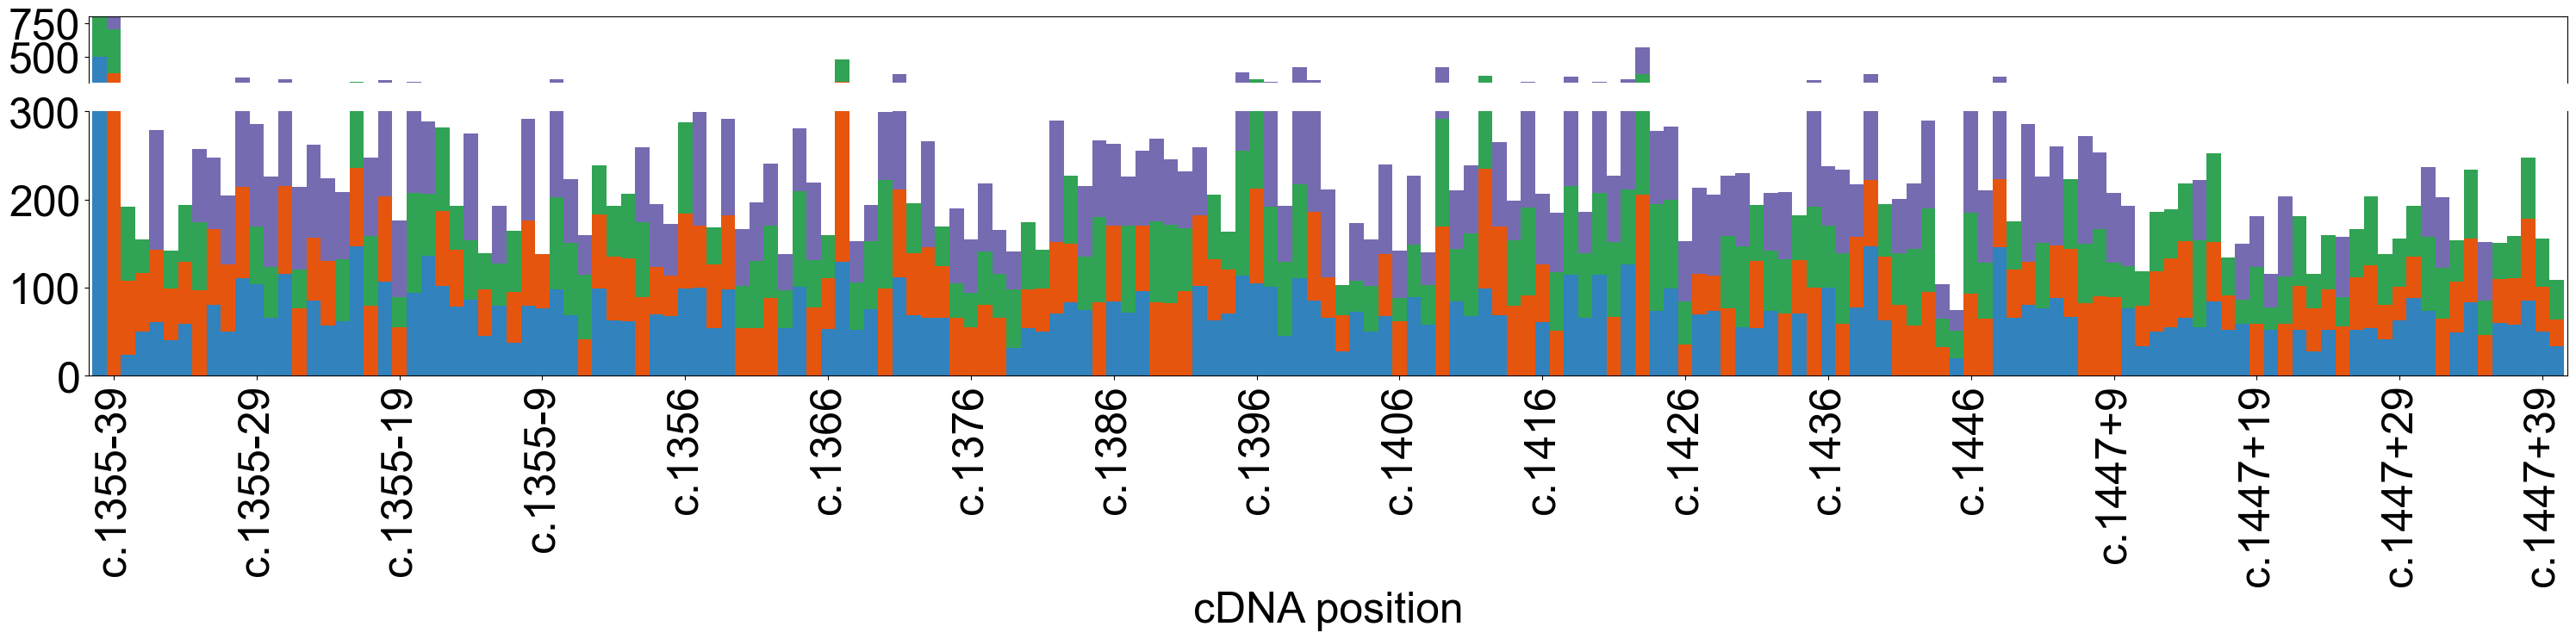

In [20]:
sp.split_ax_bcs(  byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                  [ 'n_bc_passfilt_mean' ],
                  'hgvs_pos',
                    [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                    [ ( 300.5, 800 ), ( 0, 300 ) ],
                    fig_size = ( 30, 7.5 ),
                    legend = False,
                    hratios = [ 1, 4 ],
                    x_ax_title = 'cDNA position',
                    #tight = False,
                    #savefile = plot_out + 'bcs_filt_by_pos_split.pdf'
                           )

In [64]:
byvartbl_wide.n_bc_passfilt_mean.mean()

79.7442084942085

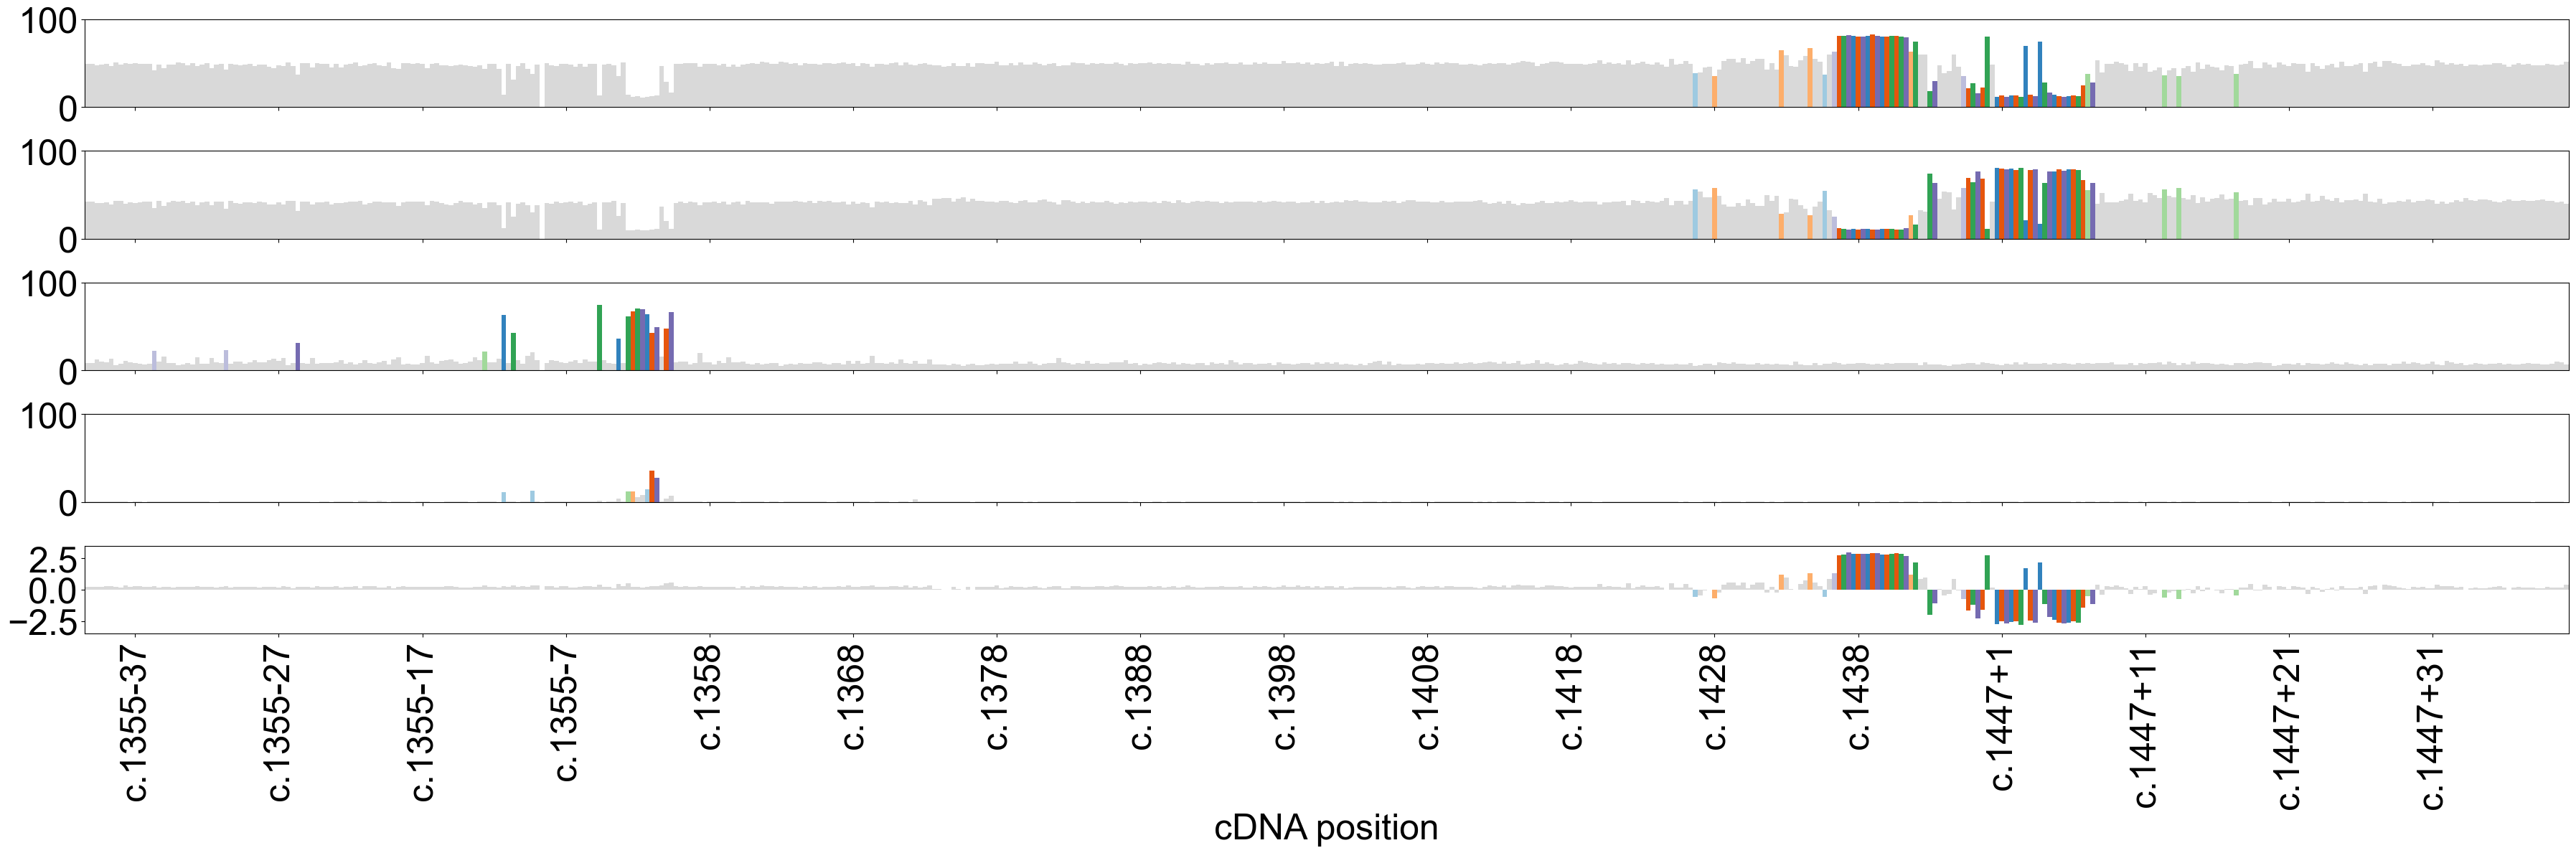

In [21]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                         [ 'wmean_KTS+_100', 'wmean_KTS-_100', 'wmean_SKIP_100', 'wmean_OTHER_100', 'KTS_+_ratio_log2' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 36, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ) ],
                          y_ax_title = [ '', '', '', '', '' ], 
                          x_ax_title = 'cDNA position',
                          tick_spacing = 10,
                          #hatch_missing = [ ( 'wmean_SKIP_100', '/' ) ],
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [38]:
byvartbl_wide.sdv.sum()

57

In [39]:
byvartbl_wide.sdv.sum() / len( byvartbl_wide )

0.11003861003861004

In [40]:
byvartbl_wide.intmed.sum()

16

In [41]:
byvartbl_wide.intmed.sum() / len( byvartbl_wide )

0.03088803088803089

In [22]:
byvartbl_wide.loc[ byvartbl_wide.lit_interp.isnull(), 'lit_interp' ] = ''

In [23]:
lit_marker_d = { '': 'o',
                 'Likely benign/benign': 's',
                 'Likely pathogenic/pathogenic (ClinVar)': '^',
                 'Likely pathogenic/pathogenic (Literature)': 'v',
                 'VUS/Conflicting': 'd' }

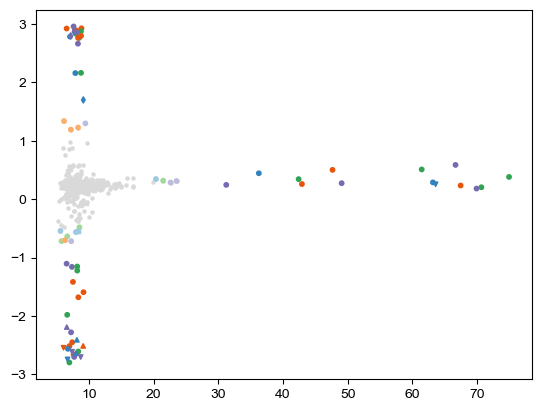

In [24]:
sp.scatter_by_sdv_alt_interp( byvartbl_wide,
                           'lit_interp',
                           'wmean_SKIP_100',
                           'KTS_+_ratio_log2',
                            tab_sdv,
                            lit_marker_d,
                            alt_col = 'alt_c',
                            intmed_col = 'intmed',
                            intmed_cmap = tab_intmed,
                            marker_size = 5 )

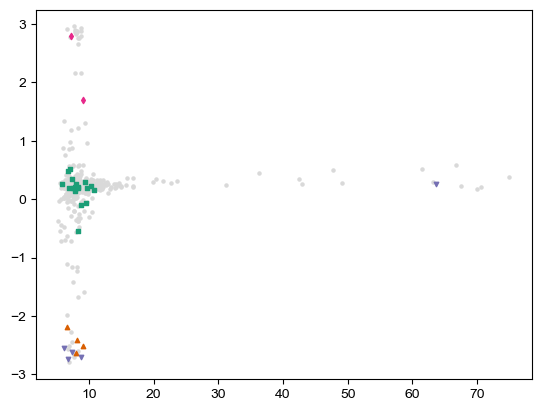

In [25]:
sp.scatter_by_interp( byvartbl_wide,
                  'lit_interp',
                   'wmean_SKIP_100',
                   'KTS_+_ratio_log2',
                    lit_marker_d,
                    cm.get_cmap( 'Dark2' ),
                    marker_size = 5 )

In [67]:
byvartbl_wide.loc[ byvartbl_wide.pos == 1262 ][ [ 'hgvs_var' ] + [ col for col in byvartbl_wide if 'per_bad_starts' in col ] ]

,hgvs_var,BB_RT_1_340_243_Hek1053_per_bad_starts,BB_RT_2_340_243_Hek1054_per_bad_starts,BB_RT_2_ODT_243_Hek1054_per_bad_starts,BB_RT_1_ODT_243_Hek1053_per_bad_starts,BB_RT_3_340_243_Cos1055_per_bad_starts,BB_RT_1b_340_243_Hek1053_per_bad_starts,BB_RT_3_340_243_Hek1055_per_bad_starts,BB_RT_1b_ODT_243_Hek1053_per_bad_starts,BB_RT_3_ODT_243_Cos1055_per_bad_starts,BB_RT_3_ODT_243_Hek1055_per_bad_starts
411,c.1355-5:T>A,0.127632,0.388350,0.000000,0.267237,0.373134,0.314861,0.534759,0.222717,0.513875,0.000000
412,c.1355-5:T>C,0.641711,0.403551,0.295858,0.336700,1.403509,0.269179,0.000000,0.277008,0.318471,0.387597
413,c.1355-5:T>G,8.085809,9.245742,6.135630,12.412587,10.855263,9.236948,9.589041,13.973799,8.926780,9.225092


In [69]:
byvartbl_wide.loc[ byvartbl_wide.pos == 1262 ].set_index( 'hgvs_var' )[ [ col for col in byvartbl_wide if 'per_bad_starts' in col ] ].median( axis = 1 )

hgvs_var
c.1355-5:T>A    0.291049
c.1355-5:T>C    0.327586
c.1355-5:T>G    9.241345
dtype: float64

In [70]:
byvartbl_wide.loc[ byvartbl_wide.pos == 1262 ].set_index( 'hgvs_var' )[ [ col for col in byvartbl_wide if '_wmean_OTHER' in col ] ].median( axis = 1 )

hgvs_var
c.1355-5:T>A    0.006167
c.1355-5:T>C    0.002570
c.1355-5:T>G    0.011503
dtype: float64

In [71]:
byvartbl_wide.loc[ byvartbl_wide.pos == 1262 ].set_index( 'hgvs_var' ).gnomad

hgvs_var
c.1355-5:T>A    False
c.1355-5:T>C    False
c.1355-5:T>G    False
Name: gnomad, dtype: bool

In [26]:
acc_plot = [ 'wmean_SKIP_100', 'wmean_OTHER_100', 'maxent_acc', 'DS_maxm_100' ]

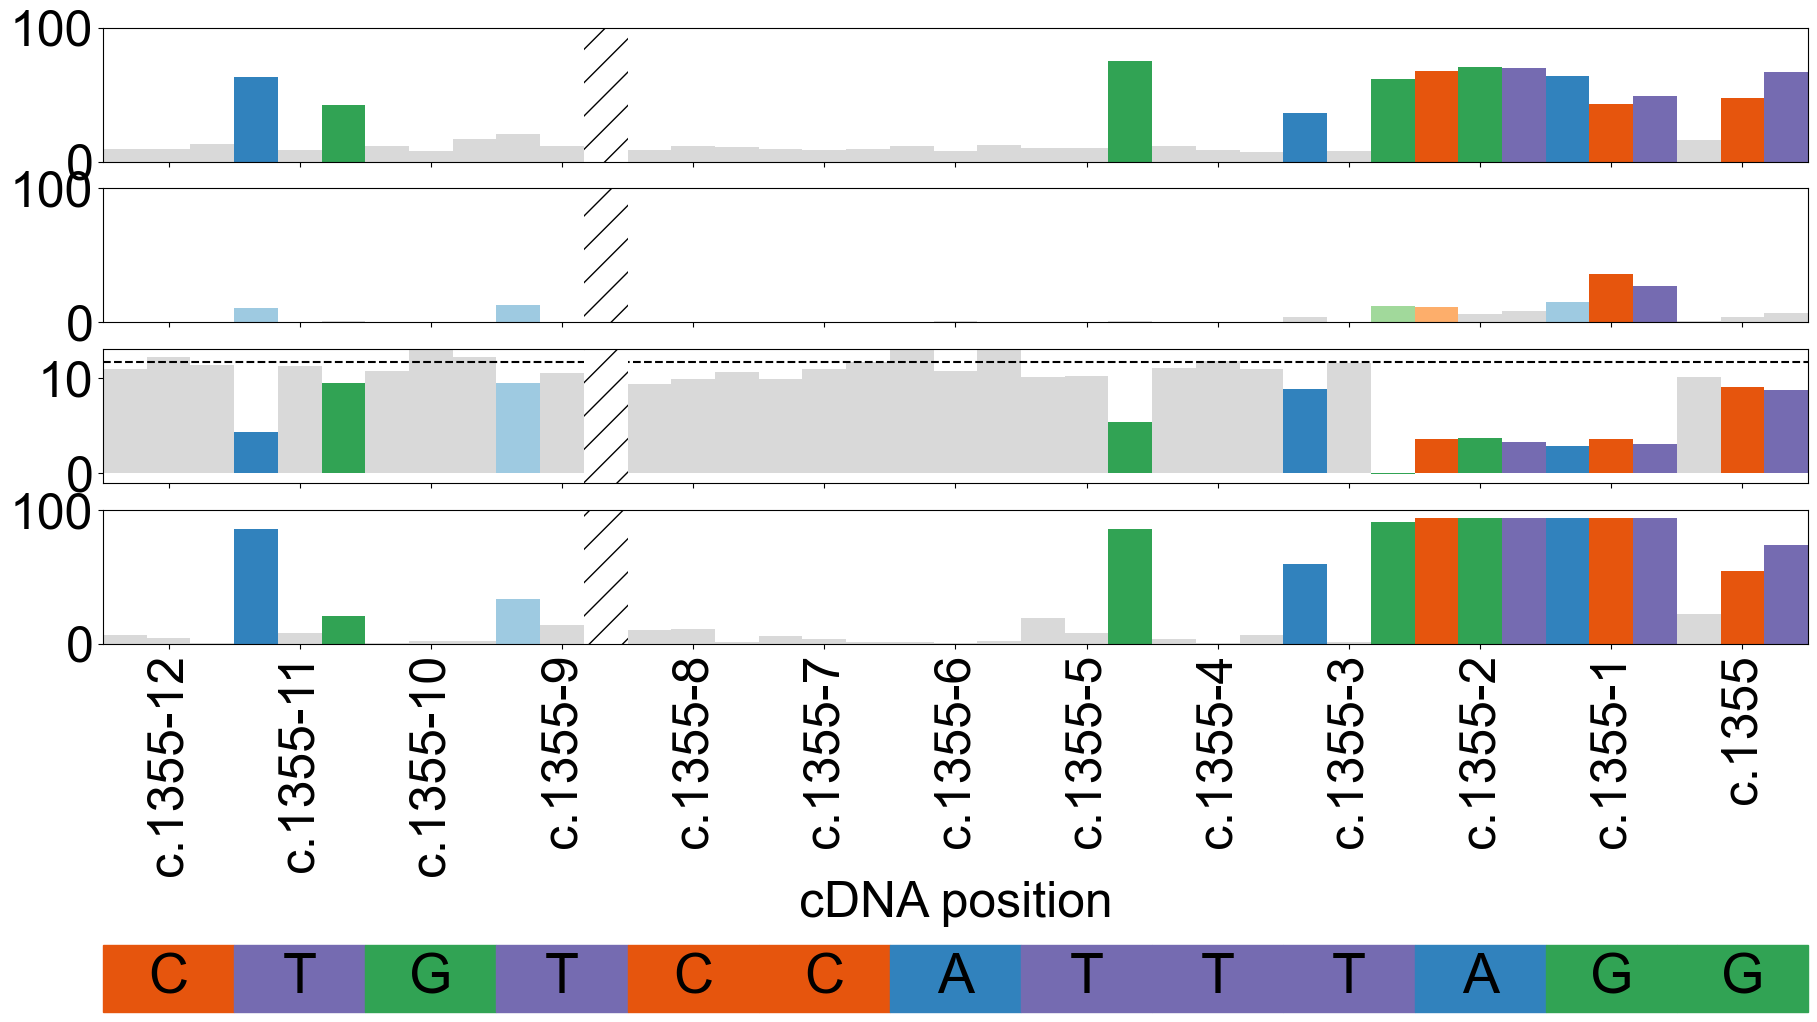

In [27]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          acc_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1255, 1267 ),
                          fig_size = ( 22, 8 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -1, 13 ), ( 0, 100 ), ],
                          y_ax_title = [ '' ]*len( acc_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -275,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          tight = False,
                          hatch_missing = [ ( 'wmean_SKIP_100', '/' ) ],
                          hlines = [ None,
                                     None,
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1267 ].maxent_wt_acc.mean(), 'black', '--' ),
                                     None,
                                     ],
                          #savefile = plot_out + 'acc_zoom.pdf'
                     )

In [59]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1255 ) & ( byvartbl_wide.pos <= 1267 ) & ( byvartbl_wide.lit_interp != '' ) ][ [ 'hgvs_var', 'lit_interp' ]]

,hgvs_var,lit_interp
399,c.1355-1:G>A,Likely pathogenic/pathogenic (Literature)
419,c.1355-7:C>T,Likely benign/benign
422,c.1355-8:C>T,Likely benign/benign
426,c.1355-10:G>C,Likely benign/benign


In [29]:
byvartbl_wide.loc[ ( byvartbl_wide.pos <= 1280 ) ].sdv.sum()

14

In [43]:
kts_plot = [ 'wmean_KTS+_100', 'wmean_KTS-_100', 'KTS_+_ratio_log2', 'maxent_KTS-', 'maxent_KTS+', 'DS_maxm_100', 'splai_KTS-_100', 'splai_KTS+_100', ]

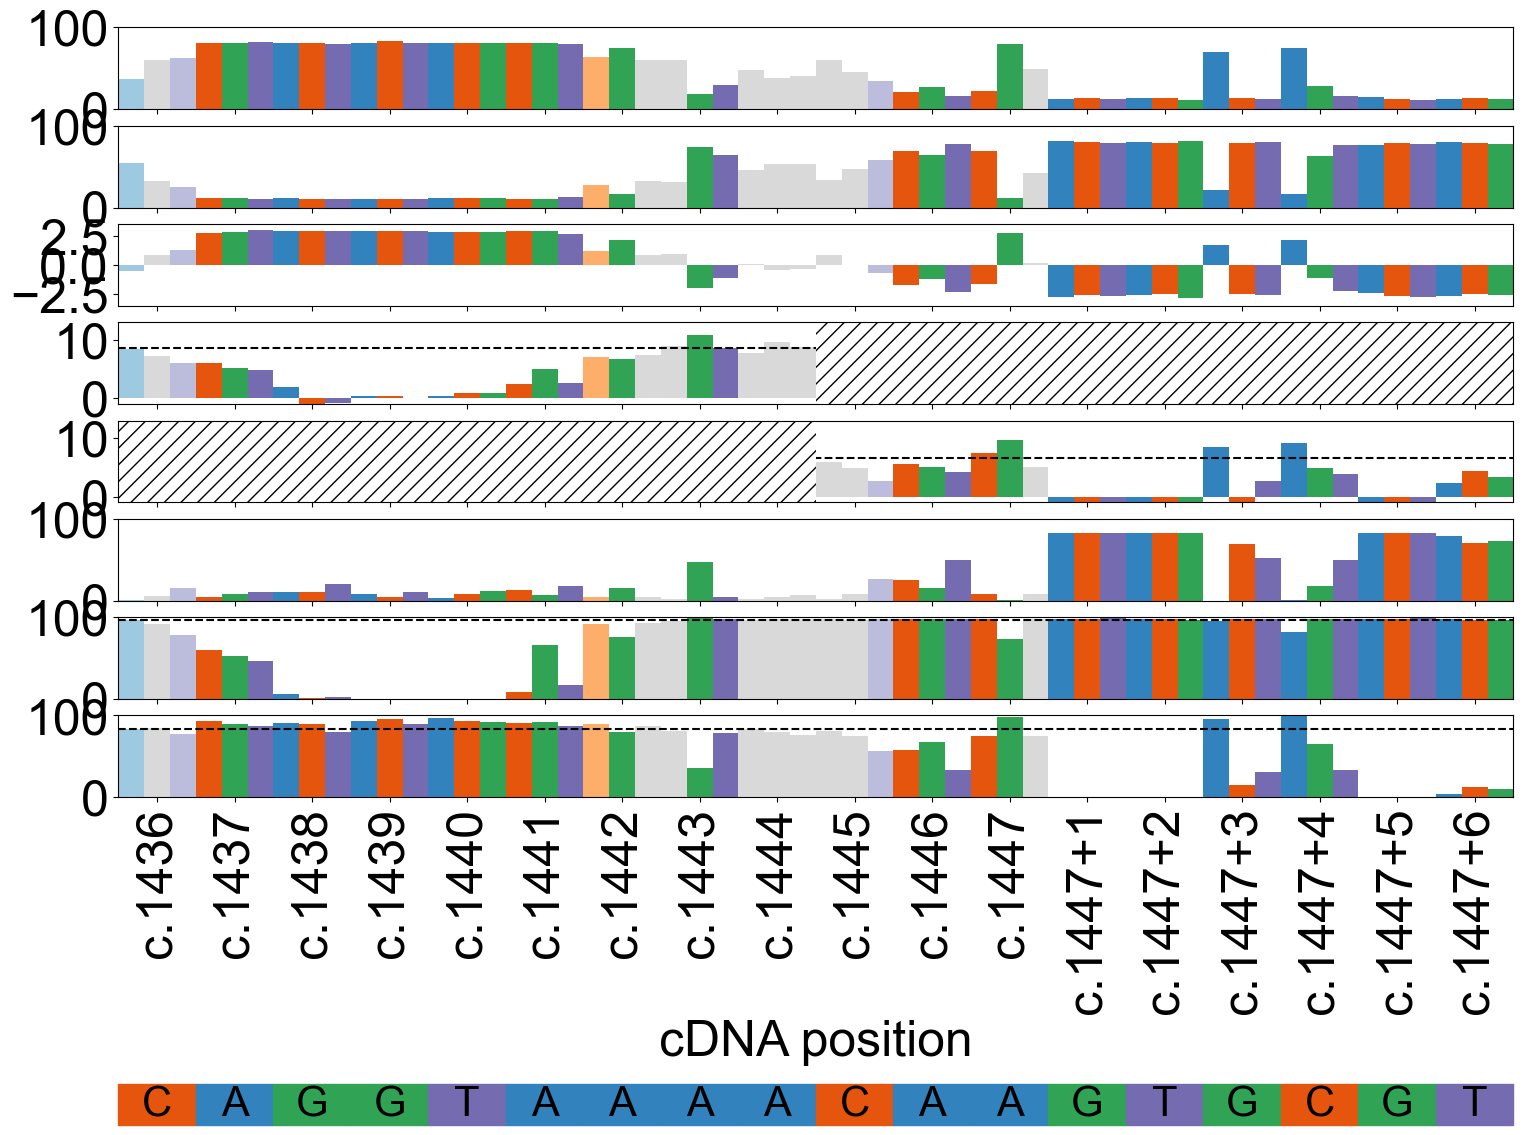

In [44]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          kts_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1348, 1365 ),
                          fig_size = ( 18, 10 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                           ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                           ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ), ( -1, 13 ), ( -1, 13 ), ( 0, 100 ), ( 0, 100 ), ( 0, 100 ) ],
                          y_ax_title = [ '' ]*len( kts_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -400,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          ref_font_size = 30,
                          hatch_missing = [ ( 'wmean_SKIP_100', '/' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ( 'maxent_KTS-', '//' ),
                                            ( 'maxent_KTS+', '//' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ],
                          hlines = [ None,
                                     None,
                                     None,
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1350 ].maxent_wt_don.mean(), 'black', '--' ),
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1359 ].maxent_wt_don.mean(), 'black', '--' ),
                                     None,
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1350 ].splai_wt_don_100.mean(), 'black', '--' ),
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1359 ].splai_wt_don_100.mean(), 'black', '--' ),
                                     ],
                          tight = False,
                          savefile = plot_out + 'kts_comb_zoom.pdf'
                     )

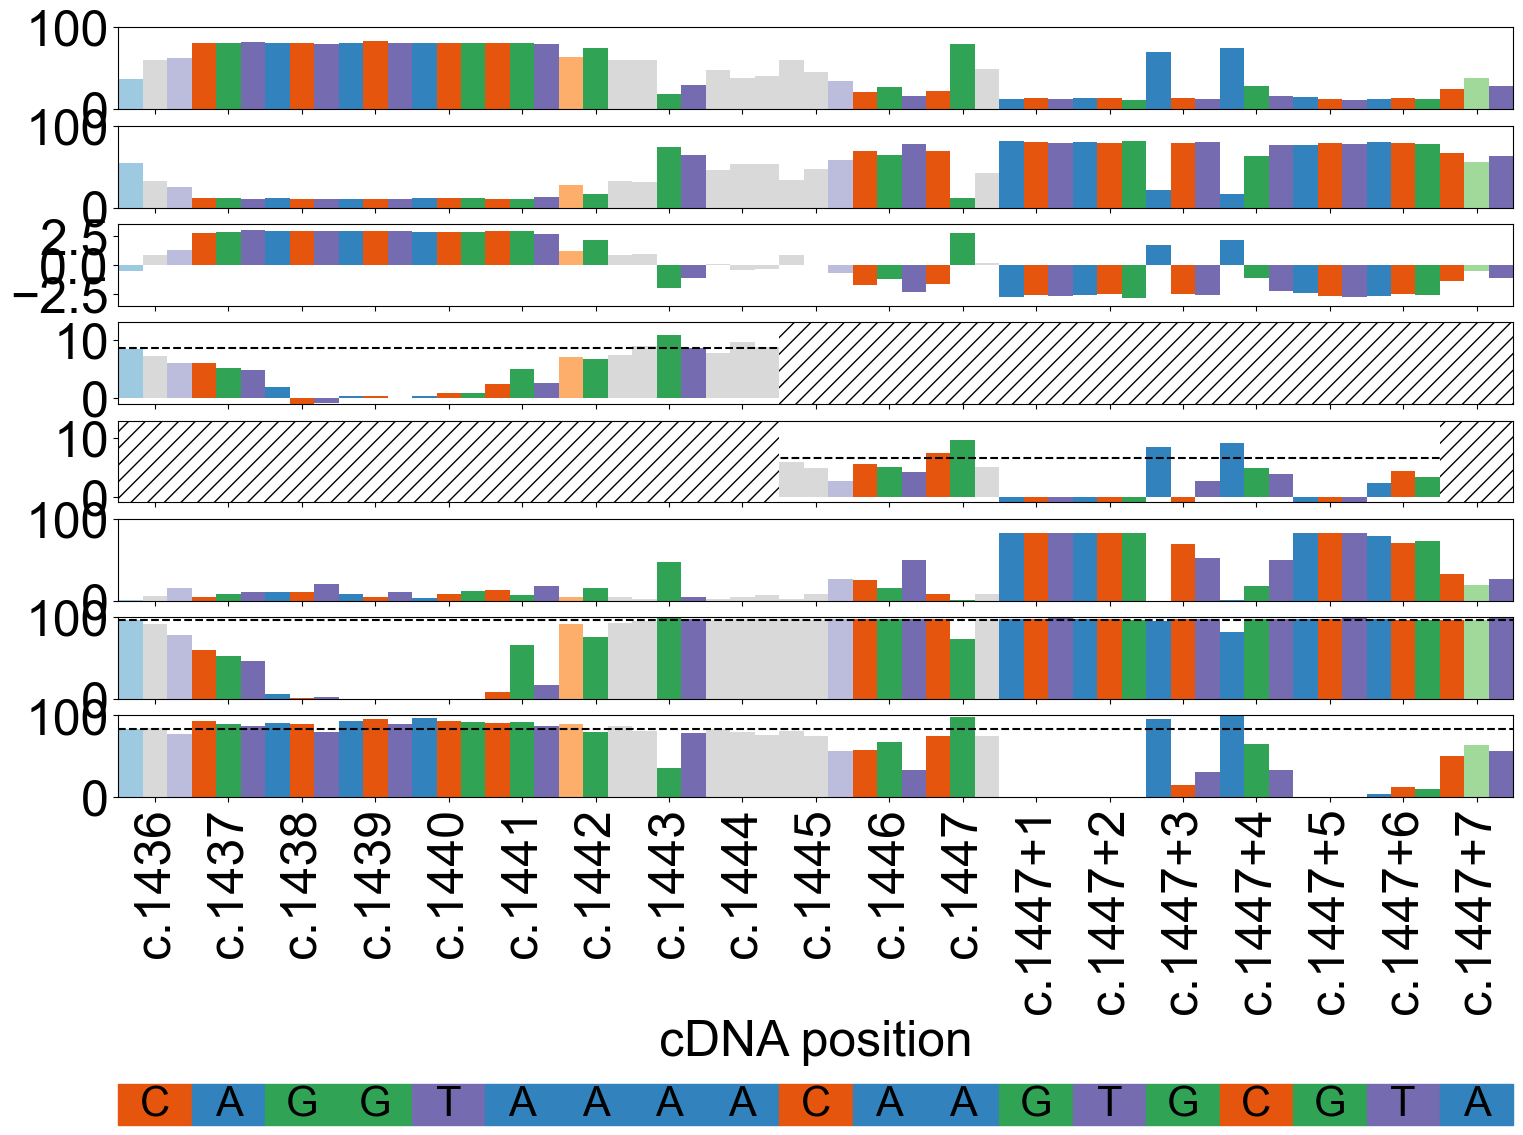

In [56]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          kts_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1348, 1366 ),
                          fig_size = ( 18, 10 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                           ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                           ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ), ( -1, 13 ), ( -1, 13 ), ( 0, 100 ), ( 0, 100 ), ( 0, 100 ) ],
                          y_ax_title = [ '' ]*len( kts_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -400,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          ref_font_size = 30,
                          hatch_missing = [ ( 'wmean_SKIP_100', '/' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ( 'maxent_KTS-', '//' ),
                                            ( 'maxent_KTS+', '//' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ],
                          hlines = [ None,
                                     None,
                                     None,
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1350 ].maxent_wt_don.mean(), 'black', '--' ),
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1359 ].maxent_wt_don.mean(), 'black', '--' ),
                                     None,
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1350 ].splai_wt_don_100.mean(), 'black', '--' ),
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1359 ].splai_wt_don_100.mean(), 'black', '--' ),
                                     ],
                          tight = False,
                          savefile = plot_out + 'kts_comb_zoom2.pdf'
                     )

In [58]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1348 ) & ( byvartbl_wide.pos <= 1366 ) & ( byvartbl_wide.lit_interp != '' ) ][ [ 'hgvs_var', 'lit_interp' ] ] 

,hgvs_var,lit_interp
100,c.1447+7:A>G,Likely benign/benign
102,c.1447+6:T>A,Likely pathogenic/pathogenic (ClinVar)
105,c.1447+5:G>A,Likely pathogenic/pathogenic (ClinVar)
107,c.1447+5:G>T,Likely pathogenic/pathogenic (Literature)
110,c.1447+4:C>T,Likely pathogenic/pathogenic (ClinVar)
111,c.1447+3:G>A,VUS/Conflicting
113,c.1447+3:G>T,Likely pathogenic/pathogenic (Literature)
115,c.1447+2:T>C,Likely pathogenic/pathogenic (ClinVar)
117,c.1447+1:G>A,Likely pathogenic/pathogenic (Literature)
118,c.1447+1:G>C,Likely pathogenic/pathogenic (Literature)


In [62]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1358 ) ].sdv.sum()

25

In [63]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1348 ) & ( byvartbl_wide.pos < 1358 ) ].sdv.sum()

18

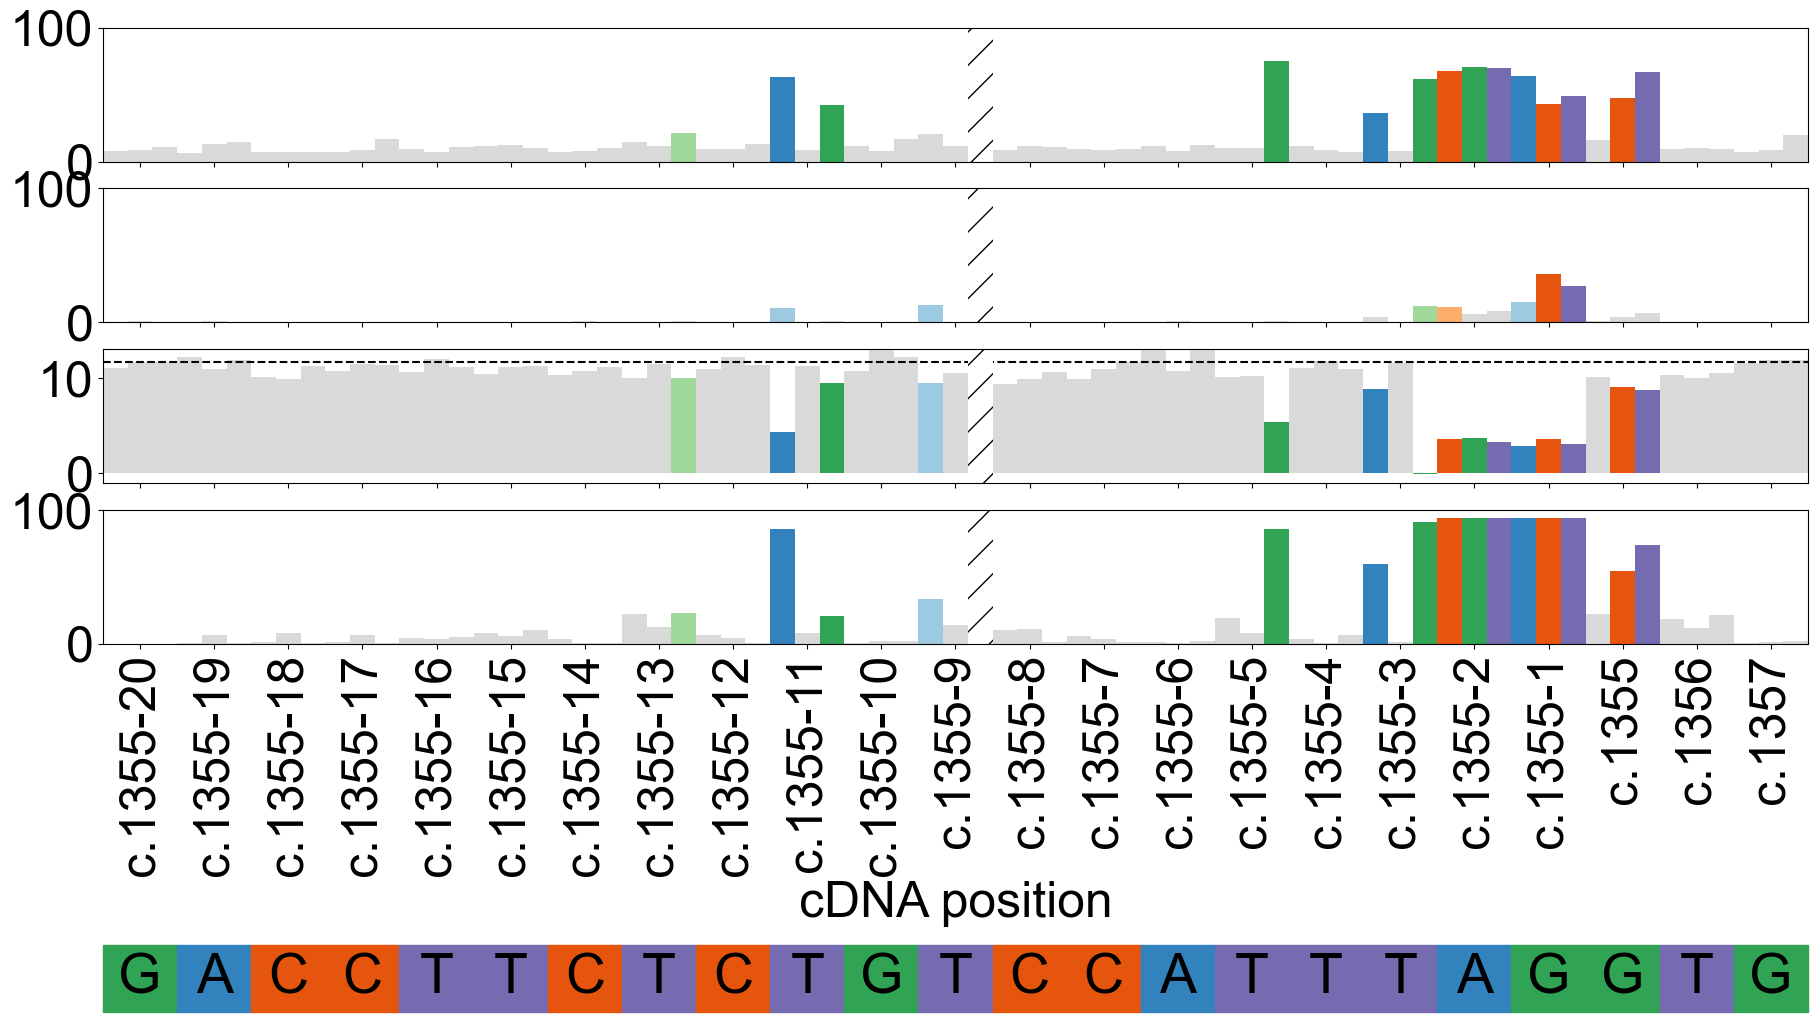

In [46]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          acc_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1247, 1269 ),
                          fig_size = ( 22, 8 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -1, 13 ), ( 0, 100 ), ],
                          y_ax_title = [ '' ]*len( acc_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -275,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          hatch_missing = [ ( 'wmean_SKIP_100', '/' ) ],
                          hlines = [ None,
                                     None,
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1267 ].maxent_wt_acc.mean(), 'black', '--' ),
                                     None,
                                     ],
                          tight = False,
                          #savefile = plot_out + 'acc_zoom.pdf'
                     )

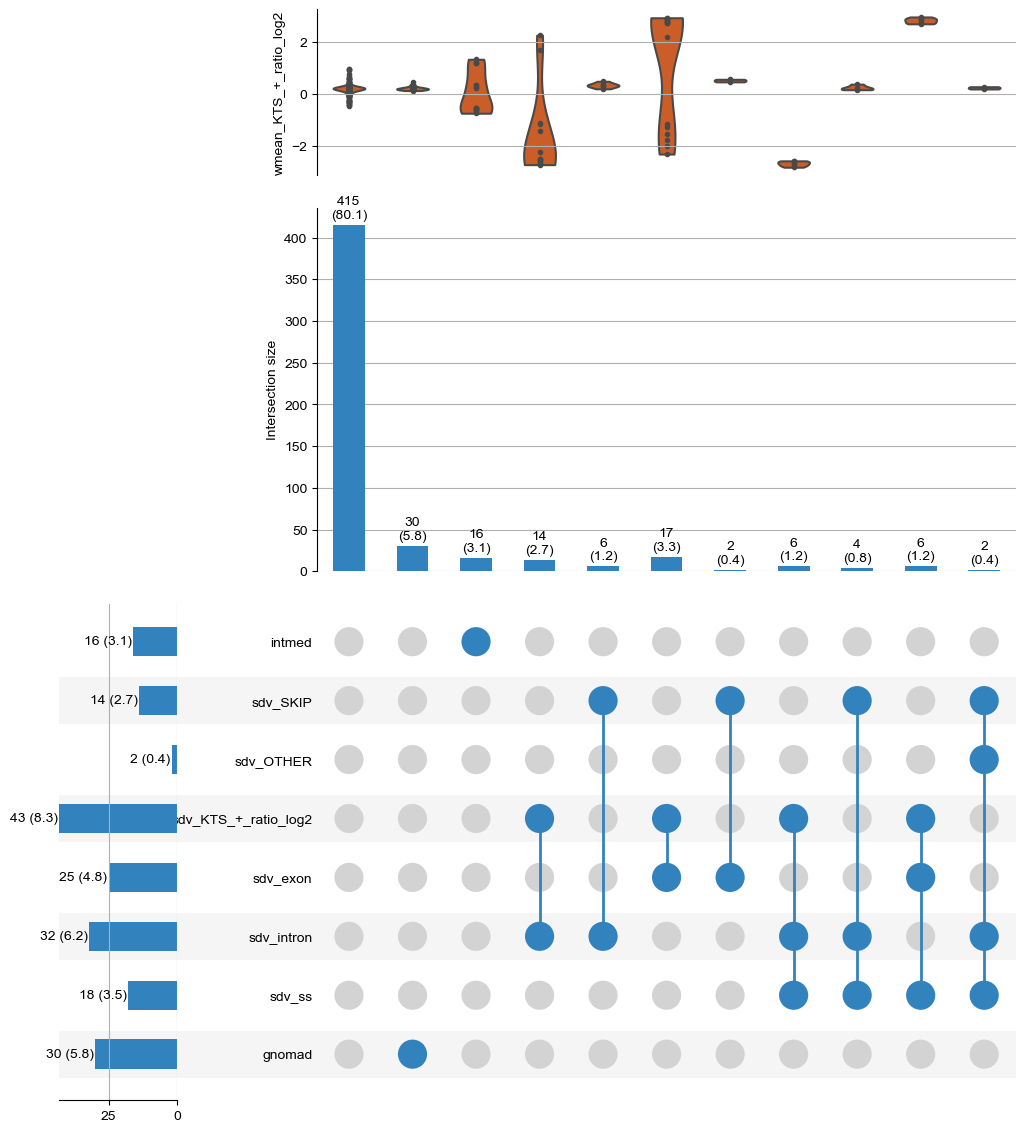

In [60]:
sp.upset_plot( byvartbl_wide, 
               [ 'intmed', 'sdv_SKIP', 'sdv_OTHER', 'sdv_KTS_+_ratio_log2', 'sdv_exon', 'sdv_intron', 'sdv_ss', 'gnomad' ][ ::-1 ],
                ( 14, 14 ),
                [ 'wmean_KTS_+_ratio_log2' ],
                [ 'violin' ],
                [ light_colors[ 4 ] ],
                show_counts = '%d',
                show_percentages = '%.1f',
                facecolor = light_colors[ 0 ],
                element_size = 60,
               sort_categories_by = None,
               savefig = plot_out + 'sdv_upset.pdf'
              )

In [61]:
byvartbl_wide.gnomad.sum()

30

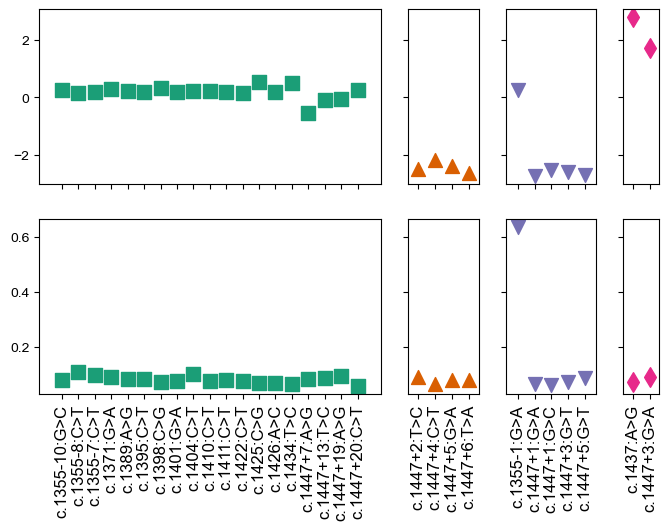

In [48]:
#moved this in from merge_lit_vars.2022-0721
tbv = byvartbl_wide.loc[ byvartbl_wide.lit_interp != '' ].copy()

fig,ax = plt.subplots( 2, len( tbv.lit_interp.unique() ),
                       gridspec_kw = { 'width_ratios' : [ len( tbv.loc[ tbv.lit_interp == l ] ) for l in tbv.lit_interp.unique() ] },
                       sharex = 'col',
                       sharey = 'row',
                       figsize = ( 8, 5 ) )

markers = [ '+', '*', '.', 'D', 'v' ]

colors = plt.get_cmap( 'Dark2' )

for i,interp in enumerate( tbv.lit_interp.unique() ):
    
    interp_df = tbv.loc[ tbv.lit_interp == interp ].sort_values( by = 'pos' ).reset_index().copy()
    
    ax[ 0 ][ i ].scatter( interp_df.index,
                     interp_df[ 'KTS_+_ratio_log2' ],
                     marker = lit_marker_d[ interp ],
                     color = colors( i ),
                     s = 100 )
    
    ax[ 1 ][ i ].scatter( interp_df.index,
                     interp_df.wmean_SKIP,
                     marker = lit_marker_d[ interp ],
                     color = colors( i ),
                     s = 100 )
    
    #i_title = interp
    
    #if '(' in i_title:
        
        #i_title = i_title.split( '(' )[ 0 ] + '\n' + i_title.split( '(' )[ 1 ][ :-1 ]
        
    #if '/' in i_title:
        
        #i_title = i_title.split( '/' )[ 0 ] + '\n' + i_title.split( '/' )[ 1 ]
    
    #ax[ 0 ][ i ].set_title( i_title )
    
    #ax[ 1 ][ i ].set_ylim( ( 0, 1 ) )
    
    x_l,x_r = ax[ 0 ][ i ].get_xlim()
    
    #my stupid markers keep getting cut off
    ax[ 0 ][ i ].set_xlim( ( x_l - .5, x_r + .5 ) )
    ax[ 1 ][ i ].set_xlim( ( x_l - .5, x_r + .5 ) )
    
    ax[ 1 ][ i ].set_xticks(  interp_df.index )
    
    ax[ 1 ][ i ].set_xticklabels( interp_df.hgvs_var,
                                  fontsize=12,
                                  rotation='vertical' )
    
#ax[ 0 ][ 0 ].set_ylabel( 'KTS+ ratio log2' )
#ax[ 1 ][ 0 ].set_ylabel( 'SKIP PSI' )

#ax[ 1 ].set_xlabel( 'hg19 position' )

plt.show()

In [49]:
byvartbl_wide.loc[ byvartbl_wide.lit_interp == 'Likely benign/benign' ].sdv.sum()

0

In [50]:
byvartbl_wide.loc[ byvartbl_wide.lit_interp == 'Likely benign/benign' ].intmed.sum()

1

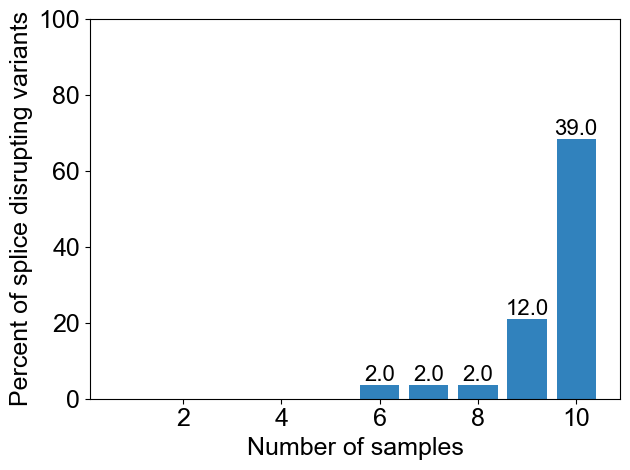

In [51]:
sp.barplot_per_repeat( byvartbl_wide.loc[ byvartbl_wide[ 'sdv' ] ],
                    'sdv_sum',
                    10,
                    ylim = ( 0, 100 ),
                    ylabel = 'Percent of splice disrupting variants',
                    xlabel = 'Number of samples',
                    #savefig = plot_out + 'sdv_by_samp.pdf',
                    color = light_colors[ 0 ]
                  )

In [52]:
bp_plot = [ 'wmean_SKIP_100', 'bp_wt_prob_100', 'DBP_max_100', 'zbpp_wt_bps', 'zbpp_wt_ppt', 'zbpp_wt', 'DS_zsc_bps_max', 'DS_zsc_ppt_max', 'DS_zsc_max' ]

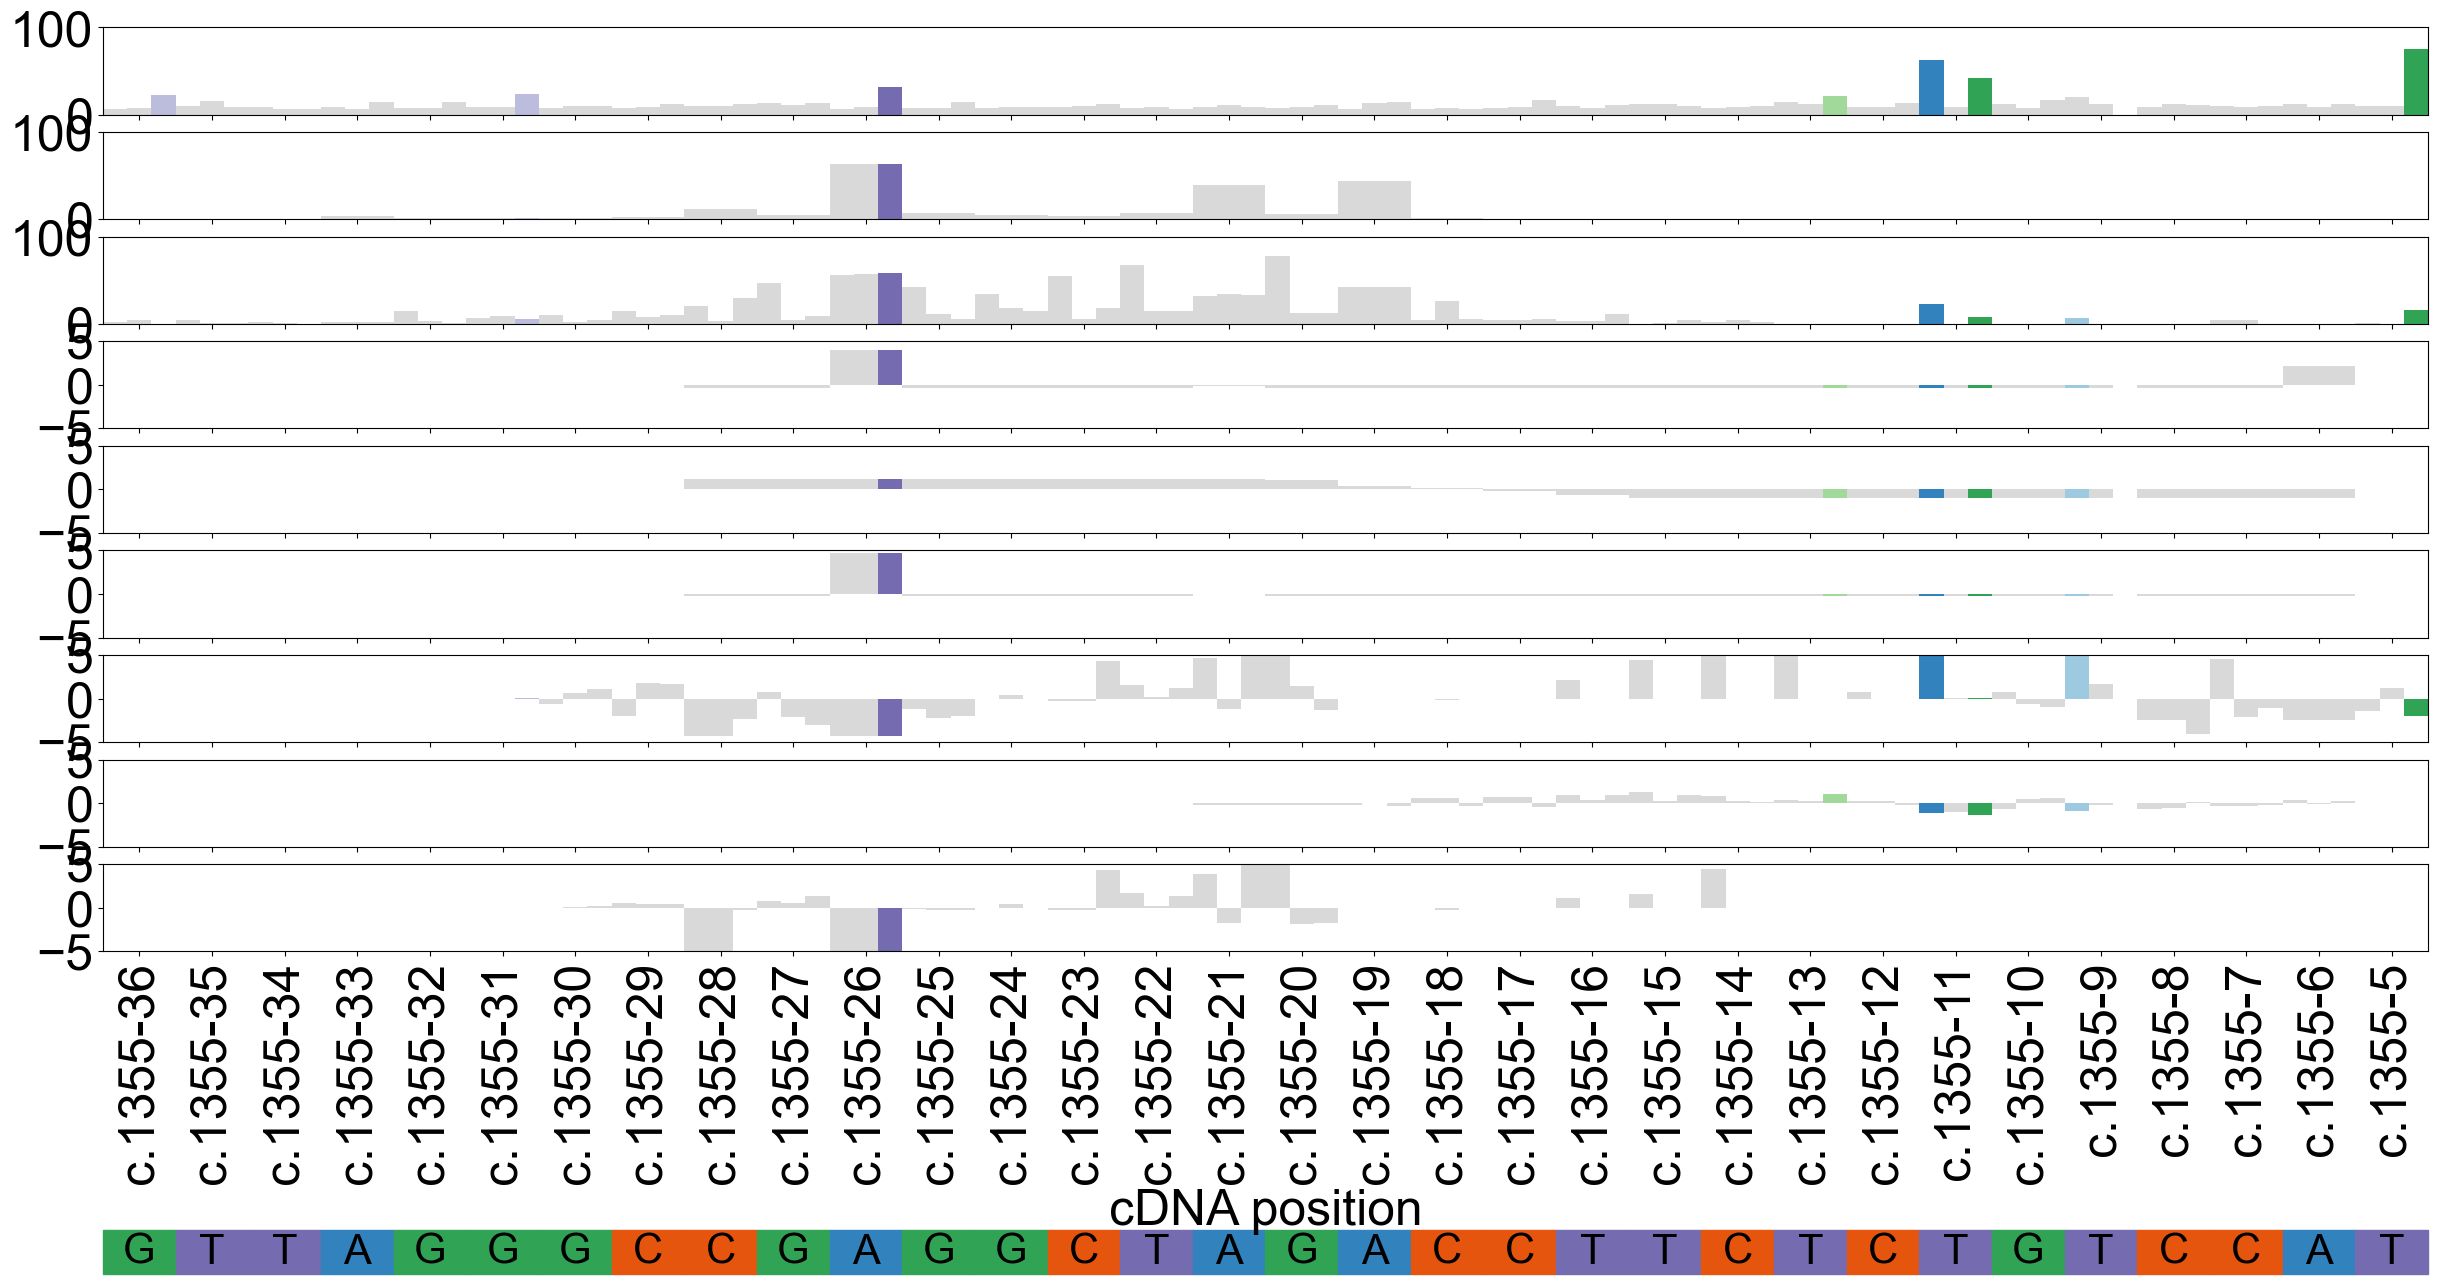

In [53]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          bp_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1231, 1262 ),
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), 
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), 
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( 0, 100 ), ( -5, 5 ), ( -5, 5 ), ( -5, 5 ), ( -5, 5 ), ( -5, 5 ), ( -5, 5 ) ],
                          y_ax_title = [ '' ]*len( bp_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -42,
                          ref_rect_ht = 5,
                          ref_font_size = 30,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          tight = False,
                          #savefile = plot_out + 'acc_zoom.pdf'
                     )

In [54]:
bp_plot2 = [ 'wmean_SKIP_100', 'bp_wt_prob_100', 'DBP_max_100', 'zbpp_wt_bps', 'DS_zsc_bps_max', 'DS_zsc_ppt_max', ]

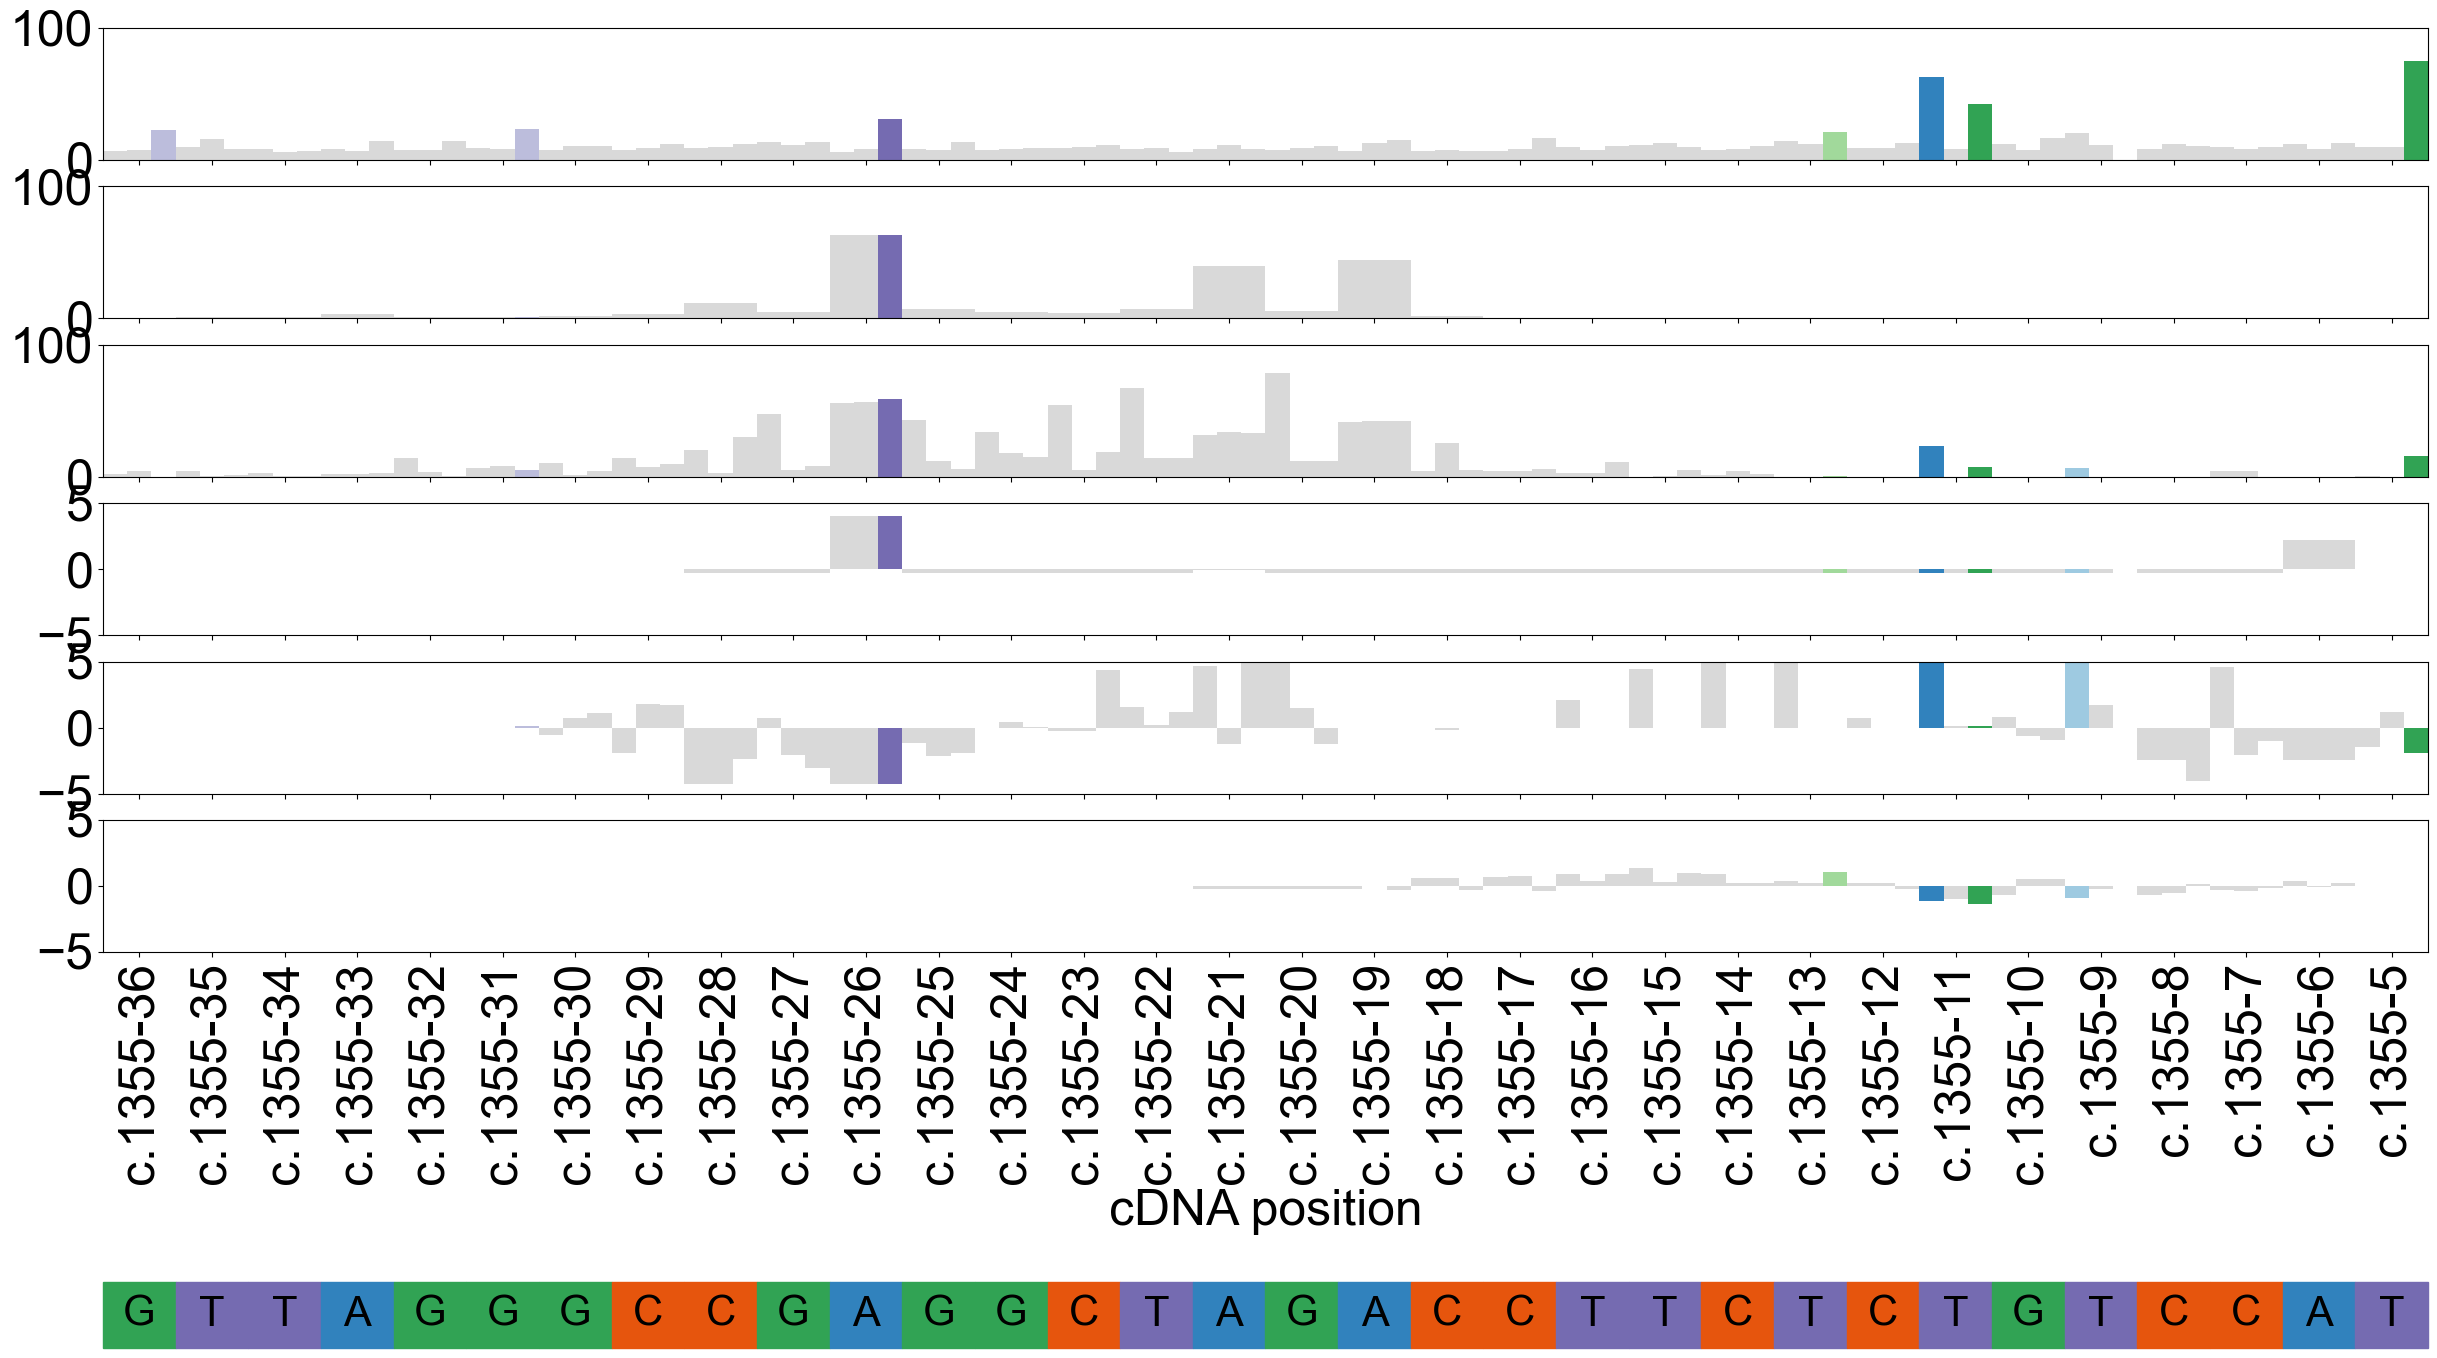

In [55]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          bp_plot2,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1231, 1262 ),
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), 
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), 
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( 0, 100 ), ( -5, 5 ), ( -5, 5 ), ( -5, 5 ) ],
                          y_ax_title = [ '' ]*len( bp_plot2 ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -35,
                          ref_rect_ht = 5,
                          ref_font_size = 30,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          tight = False,
                          #savefile = plot_out + 'acc_zoom.pdf'
                     )